In [1]:
import pandas as pd 
import pandas_datareader as data
import sys 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
def load_financial_data(start_date,end_date,symbol,output_file):
    path = sys.path[0][:-27]+"stocks/"+symbol+"|"+output_file
    try:
        df = pd.read_pickle(path)
    except FileNotFoundError:
        df = data.DataReader(symbol,'yahoo',start_date,end_date)
        df.to_pickle(path)
    return df

In this code, the following applies:

1)The classification response variable is +1 if the close price tomorrow is higher than the close price today, and -1 if the close price tomorrow is lower than the close price today.

2)For this example, we assume that the close price tomorrow is not the same as the close price today, which we can choose to handle by creating a third categorical value, 0.

In [3]:
def create_classification_trading_condition(df):
    df['Open-Close'] = df.Open - df.Close
    df['High-Low'] = df.High - df.Low
    df['Target'] = df.Close.shift(-1)-df.Close
    df = df.dropna()
    X = df[['Open-Close', 'High-Low']]
    Y = np.where(df['Close'].shift(-1) > df['Close'], 1, -1)
    return (X, Y)

In this code, the following applies:

1)It is a positive value if the price goes up tomorrow, a negative value if the price goes down tomorrow, and zero if the price does not change.

2)The sign of the value indicates the direction, and the magnitude of the response variable captures the magnitude of the price move.

In [4]:
def create_regression_trading_condition(df):
    df['Open-Close'] = df.Open - df.Close
    df['High-Low'] = df.High - df.Low
    df['Target'] = df.Close.shift(-1)-df.Close
    #df = df.dropna()
    X = df[['Open-Close', 'High-Low']]
    Y = df['Close'].shift(-1) - df['Close']
    return (X, Y)

In [5]:
def train_test_split_group(X,Y,split_ratio=0.8):
    return train_test_split(X,Y,shuffle=False,train_size=split_ratio)

In [6]:
stock_data = load_financial_data('2001-01-01','2018-01-01','TATAMOTORS.NS','TATA_data_large.pkl')

In [7]:
X, Y = create_regression_trading_condition(stock_data)

array([[<AxesSubplot:xlabel='Open-Close', ylabel='Open-Close'>,
        <AxesSubplot:xlabel='High-Low', ylabel='Open-Close'>,
        <AxesSubplot:xlabel='Target', ylabel='Open-Close'>],
       [<AxesSubplot:xlabel='Open-Close', ylabel='High-Low'>,
        <AxesSubplot:xlabel='High-Low', ylabel='High-Low'>,
        <AxesSubplot:xlabel='Target', ylabel='High-Low'>],
       [<AxesSubplot:xlabel='Open-Close', ylabel='Target'>,
        <AxesSubplot:xlabel='High-Low', ylabel='Target'>,
        <AxesSubplot:xlabel='Target', ylabel='Target'>]], dtype=object)

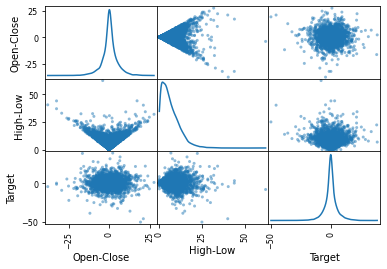

In [8]:
pd.plotting.scatter_matrix(stock_data[['Open-Close', 'High-Low','Target']], grid=True, diagonal='kde')

In [9]:
X_train,X_test,Y_train,Y_test=train_test_split_group(X,Y,split_ratio=0.8)

In [10]:
from sklearn import linear_model
ols = linear_model.LinearRegression()
ols.fit(X_train, Y_train)

LinearRegression()

In [11]:
print('Coefficients: \n', ols.coef_)

Coefficients: 
 [-0.00918543  0.01665027]


In [12]:
stock_data['Predicted Signal'] = ols.predict(X)
stock_data['NESTLEIND_return'] = (np.log(stock_data['Close'])/stock_data['Close'].shift(-1))

In [13]:
def calculate_return(df, split_value, symbol):
    cum_stock_return = df[split_value:]['%s_return' %symbol].cumsum() * 100
    df['Strategy_Returns'] = df['%s_return' % symbol] * df['Predicted Signal'].shift(1)
    return cum_stock_return

In [14]:
def calculate_strategy_return(df, split_value, symbol):
    cum_strategy_return = df[split_value:]['Strategy_Returns'].cumsum() * 100
    return cum_strategy_return

In [15]:
cum_goog_return = calculate_return(stock_data,split_value=len(X_train), symbol='NESTLEIND')
cum_strategy_return = calculate_strategy_return(stock_data,split_value=len(X_train), symbol='NESTLEIND')


In [19]:
stock_data

,High,Low,Open,Close,Volume,Adj Close,Open-Close,High-Low,Target,Predicted Signal,NESTLEIND_return,Strategy_Returns
Date,,,,,,,,,,,,
2001-01-01,17.371313,16.681442,16.949726,17.064705,5809249.0,13.780652,-0.114979,0.689871,0.900663,0.064185,0.157916,NaN
2001-01-02,18.013275,17.045542,17.055122,17.965368,10470175.0,14.507982,-0.910246,0.967733,1.513882,0.076117,0.148283,0.009518
2001-01-03,19.833767,18.013275,18.013275,19.479250,36091475.0,15.730523,-1.465975,1.820492,0.689871,0.095420,0.147223,0.011206
2001-01-04,20.657778,18.779799,19.536739,20.169121,41068816.0,16.287630,-0.632381,1.877979,-0.325773,0.088720,0.151393,0.014446
2001-01-05,20.552382,19.651716,20.312843,19.843348,30784984.0,16.024551,0.469496,0.900665,-0.440750,0.062326,0.153993,0.013662
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-26,425.149994,421.149994,422.000000,424.200012,3700655.0,424.200012,-2.200012,4.000000,-1.750000,0.138452,0.014322,0.002045
2017-12-27,428.450012,420.299988,423.500000,422.450012,3673355.0,422.450012,1.049988,8.150024,-3.850006,0.177698,0.014444,0.002000
2017-12-28,423.700012,416.000000,423.500000,418.600006,5018893.0,418.600006,4.899994,7.700012,13.250000,0.134841,0.013979,0.002484


In [20]:
def plot_chart(cum_symbol_return, cum_strategy_return, symbol):
    plt.figure(figsize=(10, 5))
    plt.plot(cum_symbol_return, label='%s Returns' % symbol)
    plt.plot(cum_strategy_return, label='Strategy Returns')
    plt.legend()

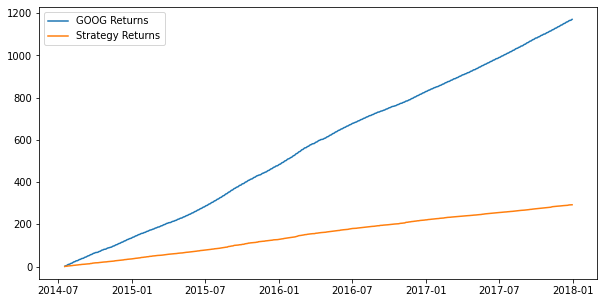

In [21]:
plot_chart(cum_goog_return, cum_strategy_return, symbol='GOOG')